# Lab/ Audio/ Audio Summary Generation

Auteur: Geoffroy Peeters 

Last update: 2021/11/24

## Introduction

The goal of this lab is to create a system that allows the automatic generation of an audio summary of a music track from the analysis of its audio content.

- the **input** of the system is an audio file (.wav) of a music track
- the **output** of the system is another audio file (.wav) that summarizes the content of the input in ``summary_duration_sec`` seconds.

The method we will use is the "summary score" proposed by [Cooper and Foote, ISMIR 2002].
The difference with the original paper (which uses MFCCs as audio features) is the use of Chroma/PCP as audio features.

You goal will be to fill in the part between ### START CODE HERE ### and ### END CODE HERE ### to complete the system.

The system is split into the following steps:

- 1) read an audio file
- 2) compute observations from the audio file at each time (a.k.a. audio features or hand-crafted features). We will use the Chroma/PCP as audio features.
    - 2a) we first need to compute the Short-Time-Fourier-Transform (spectrogram)
    - 2b) create a set of filters that allows to map the STFT to the Chroma/PCP space
    - 2c) use these filters to map the STFT to the Chroma/PCP space
- 3) compute the Self-Similarity-Matrix of the Chroma-gram/PCP-gram
- 4) compute the "summary score" of the SSM and chooses its maximum value as starting point of the audio summary
- 5) write an audio file


We will apply the method to the track "Shivers" by Ed Sheeran 

<img src="https://upload.wikimedia.org/wikipedia/en/b/b0/Ed_Sheeran_-_Shivers.png"  width=200 height=200 />


# Packages

We first import the set of necessay packages

In [103]:
%load_ext autoreload
%autoreload 2

import numpy as np
import scipy.io.wavfile as wav
import scipy.signal as sig
import matplotlib.pyplot as plt
import sys
import tpt_tools
from typing import Tuple, List, Union, Callable
%matplotlib inline

from IPython.display import Latex
do_post_processing = True

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Read the audio file

In [92]:
audio_dir = "../_audio"
# audio_file, start_sec, stop_sec, do_post_processing = os.path.join(audio_dir, 'audio_gammepno.wav'), 0, 13, False
audio_file, start_sec, stop_sec, do_post_processing = os.path.join(audio_dir, 'audio_ed_22m.wav'), 8, 3*60+47, True

sr_hz, audio_v = wav.read(audio_file)
audio_v = audio_v[start_sec*sr_hz:stop_sec*sr_hz]
print('sr_hz is {}'.format(sr_hz))
print('size of audio_v is {}'.format(audio_v.size))

sr_hz is 22050
size of audio_v is 4828950


# Compute Chroma-gram/PCP-gram from the audio signal

## Define the parameters of the system

In [93]:
# --- STFT window duration
l_sec = 0.2
# --- STFT hop-size
step_sec = 0.2/3

## Compute Short Time Fourier Transform

We first perform the short term analysis using the succession over time of short term DFT  (a.k.a. Short Time Fourier Transform).
We do this using a blackman analysis window of duration 0.2s and hop size 0.2/3s.

The conversion from seconds to samples is
- ``L_n=round(0.2 * sr_hz)`` et
- ``STEP_n=round(0.2/3 * sr_hz)``

in which sr_hz is the sampling rate (which depends on the audio file).

The DFT size $N_{fft}$ should be larger or equal to the window duration $L_n$. 
It should be a power of 2 in order to be able to use the Fast Fourier Transform algorithm (FFT). 
We will use a zero-padding factor of 4 for $N_{fft}$ which means we will take 4 times the value of $N_{fft}$ which is the first power 2 larger than $L_n$.
This zero-padding will help us creating the chroma filters for the lowest frequencies.

In [94]:
# --- Convert values from seconds (_sec) to samples (_n)
l_n = int(np.round(l_sec * sr_hz))
step_n = int(np.round(step_sec*sr_hz))
# --- Compute the DFT size using zero-padding
n_fft = 4*tpt_tools.nextpow2(l_n)

At each frame, we 
- window the signal
- compute its DFT
- store the results in a matrix

32768
(387, 16385)
(16385,)
(387,)


(0.0, 2000.0)

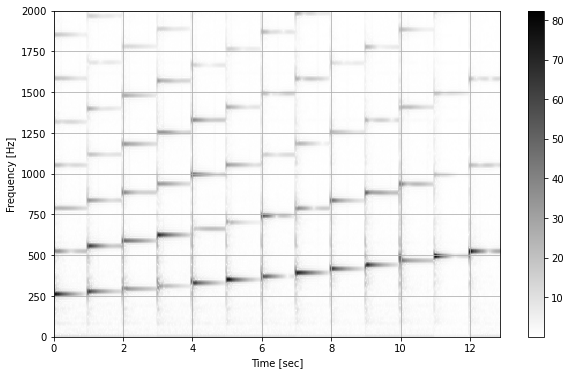

In [95]:
def F_getSTFTFromAudio(audio_v, sr_hz, l_n, step_n, n_fft):
    """[summary]

    Args:
        - audio_v: audio signal
        - sr_hz: sampling rate
        - l_n: window duration
        - step_n: hope size
        - n_fft: fft size

    Returns:
        - stft_ampl_m (nb_frames, Nfft/2+1)
        - stft_freq_hz_v (Nfft/2+1)
        - stft_time_sec_v (nb_frames,)

    """
    ### START CODE HERE ###
    nb_frames = (audio_v.shape[0] - l_n) // step_n
    stft_ampl_m = np.empty((nb_frames, n_fft//2+1))
    stft_frame_starts =  np.arange(nb_frames) * step_n
    w = sig.windows.hann(l_n)
    for frame_idx in np.arange(nb_frames):
        frame_start = stft_frame_starts[frame_idx]
        frame_stop = frame_start + l_n
        x = audio_v[frame_start:frame_stop]
        # print(audio_v.shape, x.shape, frame_stop, nb_frames)
        x_w = x * w / (2 * np.sum(w))
        stft_ampl_m[frame_idx] = np.abs(np.fft.rfft(x_w, n=n_fft))
    stft_freq_hz_v = np.fft.rfftfreq(n=n_fft) * sr_hz
    stft_time_sec_v = stft_frame_starts / sr_hz
    ### END CODE HERE ###
    return stft_ampl_m, stft_freq_hz_v, stft_time_sec_v

audio_file, start_sec, stop_sec, do_post_processing = os.path.join(audio_dir, 'audio_gammepno.wav'), 0, 13, False
# audio_file, start_sec, stop_sec, do_post_processing = os.path.join(audio_dir, 'audio_ed_22m.wav'), 8, 3*60+47, True

sr_hz, audio_v = wav.read(audio_file)
audio_v = audio_v[start_sec*sr_hz:stop_sec*sr_hz]

stft_ampl_m, stft_freq_hz_v, stft_time_sec_v = F_getSTFTFromAudio(audio_v, sr_hz, l_n, step_n, n_fft)

print(n_fft)
print(stft_ampl_m.shape)
print(stft_freq_hz_v.shape)
print(stft_time_sec_v.shape)

# +++++++++++++++++++++++++++++++
plt.figure(figsize=(10, 6))
tpt_tools.F_plot2(np.sqrt(stft_ampl_m.T), stft_freq_hz_v,  stft_time_sec_v,  'Frequency [Hz]', 'Time [sec]')
# plt.imshow(stft_ampl_m.T, aspect='auto')
plt.ylim((0,2000))
# plt.xlim((0, 10000))
# +++++++++++++++++++++++++++++++

### Test the function

When ```audioFile = './_audio/audio_gammepno.wav'```

you should obtain the following values

```(65536)
(32769, 192)
(32769,)
(192,)
```

you should obtain the following figure :

<img src="../_images/TPstruct_01.png" width=400/>

## Create the matrix containing the Chroma/PCP filters

There is 12 Chromas (or PCP-Pitch Class Profile). 

For each chroma ```c```, we will create a specific filter that perform the mapping between the values of the DFT and this specific chroma.

We denote by ```n```, the semi-tone-pitches (or midi notes). For example ```n=69``` is A-4 or 440Hz.
The chroma ```c``` corresponding to a given semi-note ```n``` is given by ```c = mod(n, 12)```.
The chroma ```c``` should therefore represents the energy existing in the DFT at all semi-pitches ```n``` such that ```c = mod(n, 12)```.

For each of these ```n```, we will create a band-pass filter centered on $n$ and extending on the left to ```n-1``` and the right to ```n+1```.

Each band-pass filter is normalized such that it sums to 1.

To create the filters we can use the following formula which maps the DFT frequencies (in Hz) ```STFT_freq_hz_v```to the corresponding midi notes ```STFT_freq_midi_v```: ```STFT_freq_midi_v = 12 * log2(STFT_freq_hz_v / 440)+69```.

The shape of the filter will be defined by the following formula:
$$H = \frac{1}{2} \tanh(\pi (1-2x))+\frac{1}{2}$$ 
in which $x$ represents the absolute value of the distance between ```n``` and ```STFT_freq_midi_v```: ```x = abs(n - STFT_freq_midi_v)```.

We will only consider the MIDI notes from 36 to 119: ```n=36 ... 119```.

The 12 chroma filters are stored in a matrix ```(12, Nfft/2+1)```, i.e. one filter per row.

/home/xabbu/anaconda3/envs/env_signal/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: divide by zero encountered in log2


(12, 16385)
(96,)


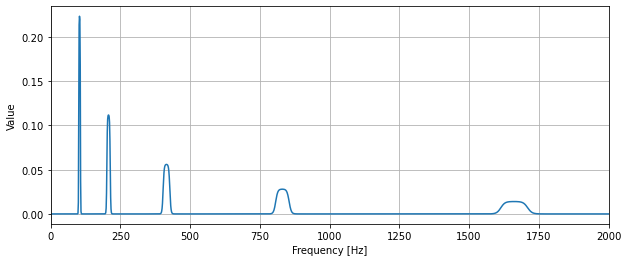

In [96]:
def F_getChromaFiltre(stft_freq_hz_v: np.ndarray, midi_start: int, midi_end: int) -> Tuple[np.ndarray, np.ndarray]:
    """
    inputs:
        - stft_freq_hz_v (N/2+1): frequency axis of the DFT in Hz
        - startMidi: starting midi note (int)
        - endMidi: ending midi note (int)
    outputs:
        - chromaFiltre_m (12, N/2+1)
        - midi_v (nbMidi)
    """
    
    ### START CODE HERE ###
    nb_chromas = 12
    midi_delta = (midi_end + 1 - midi_start)
    midi_end_corr = midi_start + nb_chromas * (midi_delta // nb_chromas  + max((midi_delta % nb_chromas), 1)) - 1
    midi_v = np.arange(midi_start, midi_end_corr+1)
    midi_m = midi_v.reshape(-1, nb_chromas)
    freq_midi_ref = { 'midi': 69, 'freq_hz': 440 }
    freq_to_midi = lambda freq_hz: 12 * np.log2(freq_hz / freq_midi_ref['freq_hz']) + freq_midi_ref['midi']
    freq_midi_v = freq_to_midi(stft_freq_hz_v)
    #
    n = midi_m[..., np.newaxis]
    n = np.tile(n, tuple(np.ones_like(midi_m.shape)) + (freq_midi_v.shape[0],))
    #
    x_h = np.abs(n - freq_midi_v)
    h_m = 0.5 * (np.tanh(np.pi * (1 - 2 * x_h)) + 1)
    midi_inrange_m = midi_m[..., np.newaxis]
    midi_inrange_m[midi_inrange_m > midi_end] = 0
    midi_amp_m = midi_inrange_m / np.sum(h_m, axis=-1, keepdims=True)
    h_m /= np.sum(h_m, axis=-1, keepdims=True)
    chroma_filter_m = np.sum(h_m, axis=0)
    ### END CODE HERE ###
    return chroma_filter_m, midi_v
    
midi_start = 36
midi_end = 120
chroma_filter_m, midi_v = F_getChromaFiltre(stft_freq_hz_v, midi_start=midi_start, midi_end=midi_end)

print(chroma_filter_m.shape)
print(midi_v.shape)
# +++++++++++++++++++++++++++++++
plt.figure(figsize=(10, 4))
tpt_tools.F_plot1(stft_freq_hz_v, chroma_filter_m[8,:], 'Frequency [Hz]', 'Value')
plt.xlim((0,2000));
# +++++++++++++++++++++++++++++++
    


### Test the function

 You should obtain the following values
 
 ``(12, 32769)
(84,)``

You should obtain the following figure
<img src="../_images/TPstruct_02.png" width=400/>

### Display all the filters as a matrix

(0.0, 1000.0)

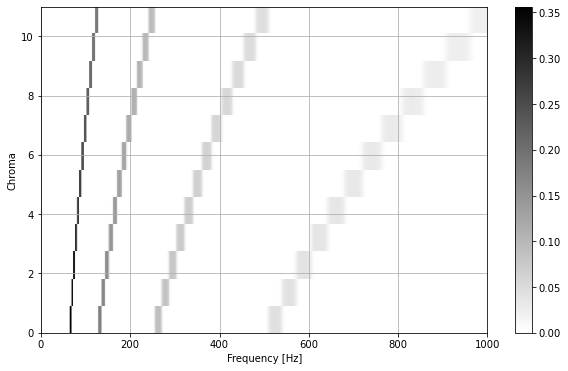

In [97]:
plt.figure(figsize=(10, 6))
tpt_tools.F_plot2(chroma_filter_m, np.arange(0, 12), stft_freq_hz_v, 'Chroma', 'Frequency [Hz]')
plt.xlim((0,1000))

You should obtain the following figure
<img src="../_images/TPstruct_03.png" width=400/>

## Compute the Chromagram

To obtain the Chroma-gram/PCP-gram, we simply multiply (matrix multiplication) the Chroma/PCP matrix with the STFT matrix:
(12, N/2+1) * (N/2+1, nbFrame) = (12, nbFrame). 

The output of this is a matrix in which the rows represent the 12 values of the chroma and the column the successive time frames.



(12, 16385)
(387, 16385)
(12, 387)


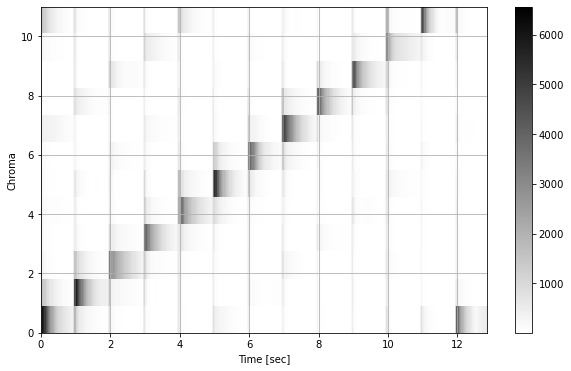

In [111]:
chroma_gram_m = chroma_filter_m @ stft_ampl_m.T

print(chroma_filter_m.shape)
print(stft_ampl_m.shape)
print(chroma_gram_m.shape)

plt.figure(figsize=(10, 6))
tpt_tools.F_plot2(chroma_gram_m, np.arange(0, 12), stft_time_sec_v, 'Chroma', 'Time [sec]')

### Test the function

When ```audioFile = './_audio/audio_gammepno.wav'```, 

you should obtain the following values

```(12, 32769)
(32769, 192)
(12, 192)
```

you should obtain the following figure
<img src="../_images/TPstruct_04.png" width=400/>

### Post-processing

To make the visualisation/detection of the structure easier we apply some post-processing. We first smooth the chromagram over time.

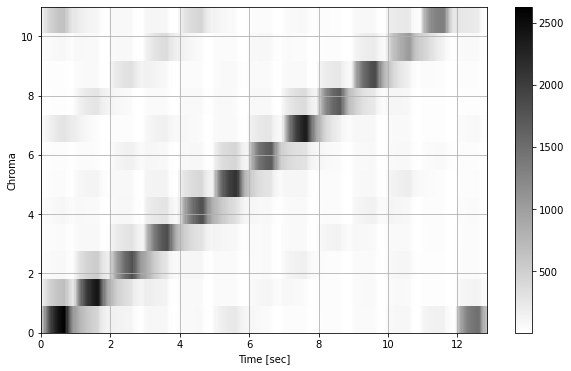

In [112]:
if do_post_processing:
    l = 21
    chroma_gram_m = sig.lfilter(np.ones(l)/l, 1, chroma_gram_m, axis=-1)
plt.figure(figsize=(10, 6))
tpt_tools.F_plot2(chroma_gram_m, np.arange(0, 12), stft_time_sec_v, 'Chroma', 'Time [sec]')  

# Compute the Self-Similarity-Matrix (time,time) using of the Chroma-gram/PCP-gram

We now compute the Self-Similarity-Matrix (SSM) using the Chroma-gram/PCP-gram.
An entry $(i,j)$ in the SSM represent the similarity between time $ t_i $ and time $t_j$.

To compute this similarity, we will use the ```cosine distance``` between the chroma vector at time $t_i$ and the one at $t_j$.

If we note $\underline{x}$ the vector at time $t_i$ and $\underline{y}$ the vector at time $t_j$, the ```cosine distance``` between them is defined as 

$$dist(\underline{x},\underline{y})=\frac{\underline{x} \cdot \underline{y}}{||\underline{x}|| \;||\underline{y}||}$$

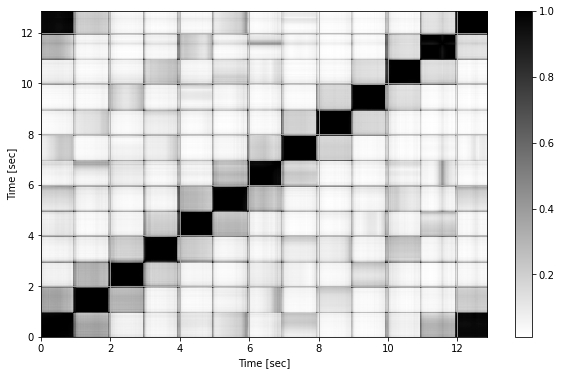

In [105]:
def F_getSsmTT(data_m: np.ndarray, dist: Callable[[np.ndarray, np.ndarray], np.ndarray]) -> np.ndarray:
    """
    inputs:
        - data_m (nbDim, nbFrame)
    outputs:
        - ssmTT_m (nbFrame, nbFrame)
    """
    
    ### START CODE HERE ###
    nb_frames = data_m.shape[-1]
    data_m_t = data_m.transpose()
    sstt_m = np.zeros((nb_frames, nb_frames))
    get_iter = lambda m: np.nditer(m, flags=['external_loop', 'f_index'], order='F')
    for l in np.arange(nb_frames):
        for c in np.arange(nb_frames):
            if c >= l:
                sstt_m[l, c] = dist(data_m_t[l], data_m_t[c])
    sstt_m += sstt_m.transpose() - np.identity(nb_frames) * sstt_m.diagonal()
    return sstt_m

import timeit

dist = lambda x, y: np.dot(x, y)/(np.linalg.norm(x)*np.linalg.norm(y))
sstt_m = F_getSsmTT(chroma_gram_m, dist)

# --- Display the matrix
plt.figure(figsize=(10, 6))
tpt_tools.F_plot2(sstt_m, stft_time_sec_v, stft_time_sec_v, 'Time [sec]', 'Time [sec]')


### Test the function

When ```audioFile = './_audio/audio_gammepno.wav'```, 

you should obtain the following figure

<img src="../_images/TPstruct_05.png" width=400/>

### Post-processing

To make the visualisation/detection of the structure easier we apply some post-processing. 
We apply a strong threshold to the SSM to only let the high values visible.

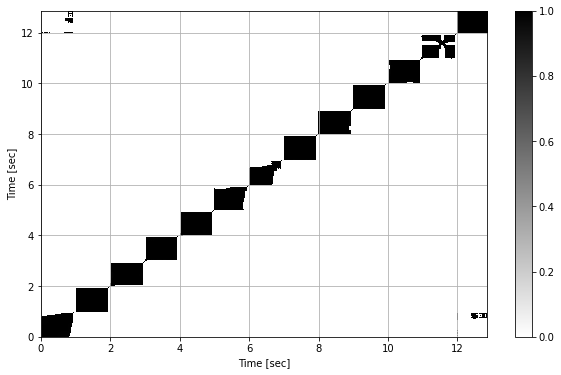

In [106]:
sstt_thres = 0.98
if do_post_processing:
    sstt_m[sstt_m<sstt_thres]=0

# --- Display the matrix
plt.figure(figsize=(10, 6))
tpt_tools.F_plot2(sstt_m, stft_time_sec_v, stft_time_sec_v, 'Time [sec]', 'Time [sec]')

# Get the best position for the start of the summary

To get the best position for the start of the summary ``startPos_frame``, we will compute the ``summary_score_v`` of the SSM. 

We then choose its maximum value as the start of our audio summary.
Indeed, this maximum value represent the best starting point of a segment of duration ``summary_duration_sec`` such that this segment best represent (is the most similar to) the whole content of the music track.

Computation of the ``summary_score_v`` as proposed by [Cooper, Foote, 2002]:
- For each time ``q`` (row q in the matrix), the summary score is computed as the sum over the column of the matrix for this specific row. It represents the similarity between the specific time ``q`` and the rest of the music track.
- For a segment starting at ``q`` and of duration ``L``, the summary score is computed as the sum over the part of the columns between ``q`` and ``q+L``. It represents the similarity between the segment ``[q,q+L]`` and the rest of the music track.
- ``L`` is imposed as the length of the audio summary (``summary_duration_sec`` in our case).

Since we look for the best summary of duration ``summary_duration_sec``, we look for the value of ``q`` which maximizes the summary score.

In [ ]:
def F_getSummaryScore(ssmTT_m, summary_duration_frame):
    """
    inputs:
        - ssmTT_m (nbFrame, nbFrame)
        - summary_duration_frame
    outputs:
        - startPos_frame
        - summary_score_v (nbFrame)
    """
    
    if do_student:
        ### START CODE HERE ###
        ...
        ### END CODE HERE ###
    
    return startPos_frame, summary_score_v

#### Display the summary length for various duration of summary

In [ ]:
# --- define the duration of the summary in seconds
summary_duration_sec = 20

### Test the function

In [ ]:
# --- convert it to number of frames
summary_duration_frame, summary_duration_n = int(summary_duration_sec/STEP_sec), int(summary_duration_sec*sr_hz)
print("Duration in sec:{} in samples:{} in frames:{}".format(summary_duration_sec, summary_duration_n, summary_duration_frame))

startPos_frame, summary_score_v = F_getSummaryScore(ssmTT_m, summary_duration_frame)
startPos_sec, startPos_n = startPos_frame*STEP_sec, int(startPos_frame*STEP_sec*sr_hz)

#### Display the resuting score function and estimated starting point of the audio summary

In [ ]:
plt.figure(figsize=(10, 6))
tpt_tools.F_plot1(STFT_time_sec_v, summary_score_v, 'frame', 'score')
plt.plot(startPos_sec, summary_score_v[startPos_frame], 'ro')
print("Start sec:{}, samples:{} frames:{}".format(startPos_sec, startPos_n, startPos_frame))

#### Display the selected segment over the Self-Similarity-Matrix

In [ ]:
plt.figure(figsize=(15, 12))
tpt_tools.F_plot2(ssmTT_m, STFT_time_sec_v, STFT_time_sec_v, 'Time [sec]', 'Time [sec]')
plt.plot(startPos_sec, startPos_sec, 'ro')
plt.plot(startPos_sec+summary_duration_sec, startPos_sec+summary_duration_sec, 'ro')

# Generate the audio summary

The audio summary is then simply the segment starting at ```startPos``` and of duration ```duration```.

In [ ]:
scipy.io.wavfile.write(audioFile.replace('.wav', '-summary.wav'), sr_hz, audio_v[startPos_n:startPos_n+summary_duration_n])